# Kickstarter: Classification
Tests Include:
-KNN
-Logistic Regression
-Decision Trees
-Random Forest
-SVM
-Gradient Boosting

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
%matplotlib inline

import sqlalchemy
from sqlalchemy import create_engine
from flask_sqlalchemy import SQLAlchemy

from sklearn import naive_bayes
from sklearn.naive_bayes import GaussianNB, BernoulliNB,MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, roc_auc_score
from sklearn.metrics import average_precision_score, precision_recall_curve, auc
from sklearn.learning_curve import learning_curve
from sklearn.cross_validation import train_test_split, cross_val_predict
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.preprocessing import label_binarize, scale, StandardScaler
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import make_pipeline

from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (RandomTreesEmbedding, RandomForestClassifier,
                              GradientBoostingClassifier)
from sklearn.preprocessing import OneHotEncoder

import datetime
import warnings
import os

warnings.filterwarnings("ignore") #, category=DeprecationWarning)

/Users/brianmcmahon/anaconda3/envs/tensorflow1.4/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/brianmcmahon/anaconda3/envs/tensorflow1.4/lib/python3.5/site-packages/sklearn/learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


In [2]:
# env variable at tensorflow1.4 per https://conda.io/docs/user-guide/tasks/manage-environments.html#saving-environment-variables
# and https://vsupalov.com/flask-sqlalchemy-postgres/

def get_env_variable(name):
    try:
        return os.environ[name]
    except KeyError:
        message = "Expected environment variable '{}' not set.".format(name)
        raise Exception(message)

# the values of those depend on your setup
POSTGRES_URL = get_env_variable("POSTGRES_URL")
POSTGRES_USER = get_env_variable("POSTGRES_USER")
POSTGRES_PW = get_env_variable("POSTGRES_PW")
POSTGRES_DB = get_env_variable("POSTGRES_DB")

In [3]:
DB_URL = 'postgresql+psycopg2://{user}:{pw}@{url}/{db}'.format(user=POSTGRES_USER,pw=POSTGRES_PW,url=POSTGRES_URL,db=POSTGRES_DB)

In [4]:
engine_var = DB_URL
engine = create_engine(engine_var)

In [5]:
df = pd.read_pickle('data/kickstarter_data_ds2.pkl')
df['idx'] = df['id']
df = df.set_index('idx')
# df = pd.read_sql_query('''SELECT * FROM kickstarter_data_ds2''',engine)
df['state'] = df['state'].replace({'failed': 0, 'successful': 1})
print(df.shape)
# pd.read_sql_query('''SELECT state, main_category, main_category, currency, currency, deadline, launched, usd_goal_real, usd_pledged_real FROM kickstarter_data_ds2 LIMIT 5''',engine)
df.head()

(163426, 19)


,id,name,state,category_main,category_name,backers_count,pct_goal_achieved,usd_pledged,goal,country,currency,campaign_length,deadline,launched,created,spotlight,staff_pick,creator_name,blurb_length
idx,,,,,,,,,,,,,,,,,,,
1725323227,1725323227,Inspire young girls,0,fashion,Childrenswear,1,0.0,30.0,1300.0,US,USD,30,2018-01-12,2017-12-13,2017-12-08,0,0,Rayna,6
2065169465,2065169465,Cotton-Top Pastries,1,food,Small Batch,99,1.3,9858.0,7500.0,US,USD,30,2018-01-12,2017-12-13,2017-12-12,1,1,Holly Weist,5
1516902916,1516902916,Dreaming Creek Brewery,0,food,Drinks,64,0.3,6139.0,20000.0,US,USD,30,2018-01-12,2017-12-13,2017-08-11,0,0,Mike Bradley,19
1396766240,1396766240,Ripple Playing Cards - Printed by USPCC,0,games,Playing Cards,131,0.3,3387.0,9999.0,US,USD,38,2018-01-12,2017-12-05,2017-10-08,0,0,B.Y. Eidelman,16
1361347175,1361347175,New Boutique Funding for the San Antonio Stock...,0,fashion,Ready-to-wear,0,0.0,0.0,5000.0,US,USD,15,2018-01-12,2017-12-28,2017-12-22,0,0,Darrian Fosty,26


In [6]:
df.corr().sort_values('pct_goal_achieved')

,id,state,backers_count,pct_goal_achieved,usd_pledged,goal,campaign_length,spotlight,staff_pick,blurb_length
campaign_length,0.005132,-0.089713,0.005262,-0.005518,0.015577,0.024512,1.000000,-0.089713,-0.009769,0.037886
blurb_length,0.000127,0.001067,-0.014007,-0.002317,-0.012107,-0.006230,0.037886,0.001067,-0.021289,1.000000
id,1.000000,-0.003152,-0.001976,-0.001247,-0.000432,0.002321,0.005132,-0.003152,0.001571,0.000127
goal,0.002321,-0.033583,0.008978,-0.000705,0.010378,1.000000,0.024512,-0.033583,-0.006790,-0.006230
staff_pick,0.001571,0.257919,0.152855,0.002356,0.143260,-0.006790,-0.009769,0.257919,1.000000,-0.021289
usd_pledged,-0.000432,0.107856,0.810093,0.008385,1.000000,0.010378,0.015577,0.107856,0.143260,-0.012107
backers_count,-0.001976,0.116075,1.000000,0.011663,0.810093,0.008978,0.005262,0.116075,0.152855,-0.014007
state,-0.003152,1.000000,0.116075,0.017137,0.107856,-0.033583,-0.089713,1.000000,0.257919,0.001067
spotlight,-0.003152,1.000000,0.116075,0.017137,0.107856,-0.033583,-0.089713,1.000000,0.257919,0.001067
pct_goal_achieved,-0.001247,0.017137,0.011663,1.000000,0.008385,-0.000705,-0.005518,0.017137,0.002356,-0.002317


In [7]:
start_date = datetime.datetime.strptime('2016-01-01', "%Y-%m-%d").date()

df = df[df['launched'] >= start_date] # filter from start date to current
df.shape

(41894, 19)

In [8]:
df_success = df[df['state'] == 1]
df_fail = df[df['state'] == 0]
print(df_success.shape)
df_success.head()

(21068, 19)


,id,name,state,category_main,category_name,backers_count,pct_goal_achieved,usd_pledged,goal,country,currency,campaign_length,deadline,launched,created,spotlight,staff_pick,creator_name,blurb_length
idx,,,,,,,,,,,,,,,,,,,
2065169465,2065169465,Cotton-Top Pastries,1,food,Small Batch,99,1.3,9858.000000,7500.0,US,USD,30,2018-01-12,2017-12-13,2017-12-12,1,1,Holly Weist,5
549309727,549309727,Higher Grounds Coffee Company Mobile Coffee Tr...,1,food,Food Trucks,61,1.0,10060.000000,10000.0,US,USD,36,2018-01-12,2017-12-07,2017-08-16,1,0,Katreena Powell,21
2090250769,2090250769,Tech Lab at Visual Philosophy,1,art,Mixed Media,42,1.0,10100.000000,10000.0,US,USD,30,2018-01-12,2017-12-13,2017-12-01,1,0,Yori and Dana Seeger,22
1339075969,1339075969,Run This Place - The Book,1,publishing,Nonfiction,483,1.0,20190.220000,20000.0,US,USD,30,2018-01-12,2017-12-13,2017-12-12,1,0,Dane Rauschenberg,18
1756145145,1756145145,WANGTA: a novel,1,publishing,Fiction,13,0.8,427.185132,550.0,CA,CAD,21,2018-01-12,2017-12-22,2017-12-18,1,0,D. H. de Bruin,22


In [9]:
print(df_fail.shape)
df_fail.head()

(20826, 19)


,id,name,state,category_main,category_name,backers_count,pct_goal_achieved,usd_pledged,goal,country,currency,campaign_length,deadline,launched,created,spotlight,staff_pick,creator_name,blurb_length
idx,,,,,,,,,,,,,,,,,,,
1725323227,1725323227,Inspire young girls,0,fashion,Childrenswear,1,0.0,30.0,1300.0,US,USD,30,2018-01-12,2017-12-13,2017-12-08,0,0,Rayna,6
1516902916,1516902916,Dreaming Creek Brewery,0,food,Drinks,64,0.3,6139.0,20000.0,US,USD,30,2018-01-12,2017-12-13,2017-08-11,0,0,Mike Bradley,19
1396766240,1396766240,Ripple Playing Cards - Printed by USPCC,0,games,Playing Cards,131,0.3,3387.0,9999.0,US,USD,38,2018-01-12,2017-12-05,2017-10-08,0,0,B.Y. Eidelman,16
1361347175,1361347175,New Boutique Funding for the San Antonio Stock...,0,fashion,Ready-to-wear,0,0.0,0.0,5000.0,US,USD,15,2018-01-12,2017-12-28,2017-12-22,0,0,Darrian Fosty,26
751080010,751080010,The Face of the Deep EP is almost ready for re...,0,music,Electronic Music,4,0.4,165.0,425.0,US,USD,30,2018-01-12,2017-12-13,2017-12-09,0,0,The Face of the Deep,22


In [10]:
df_success.pct_goal_achieved.mean()
df_fail.pct_goal_achieved.mean()

0.0813454335926246

In [11]:
df.columns

Index(['id', 'name', 'state', 'category_main', 'category_name',
       'backers_count', 'pct_goal_achieved', 'usd_pledged', 'goal', 'country',
       'currency', 'campaign_length', 'deadline', 'launched', 'created',
       'spotlight', 'staff_pick', 'creator_name', 'blurb_length'],
      dtype='object')

In [12]:
df['category_name'].unique()

array(['Childrenswear', 'Small Batch', 'Drinks', 'Playing Cards',
       'Ready-to-wear', 'Food Trucks', 'Electronic Music', 'Flight',
       'Mixed Media', 'Farms', 'Nonfiction', 'Fiction', 'Comedy',
       'Television', 'Hip-Hop', 'Web', 'Music Videos', 'Stationery',
       'Performance Art', 'Graphic Novels', 'Horror', 'Restaurants',
       'Cookbooks', '3D Printing', 'Jazz', 'Apps', 'Accessories',
       'Illustration', 'Periodicals', 'Plays', "Children's Books",
       'Sound', 'Dance', 'Zines', 'Fine Art', 'Translations', 'Jewelry',
       'Radio & Podcasts', 'Anthologies', 'Video Art', 'Candles',
       'Mobile Games', 'Graphic Design', 'Photobooks', 'Latin',
       'Literary Spaces', 'DIY', 'Footwear', 'Apparel', 'Drama',
       'Performances', 'Hardware', 'Webseries', 'Gaming Hardware',
       'Nature', 'World Music', 'Blues', 'Audio', 'Workshops',
       'Narrative Film', 'Movie Theaters', 'Couture', 'Architecture',
       'Animation', 'Experimental', 'Spaces', 'Crafts', 'Art

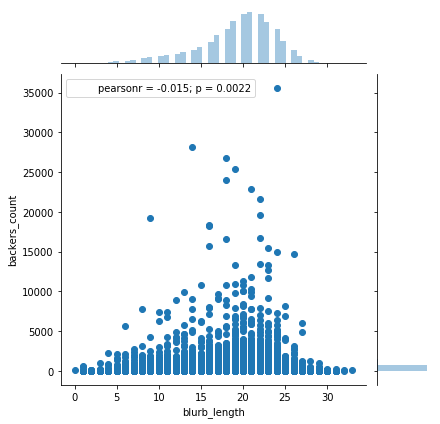

In [13]:
sns.jointplot(x='blurb_length',y='backers_count', data=df)

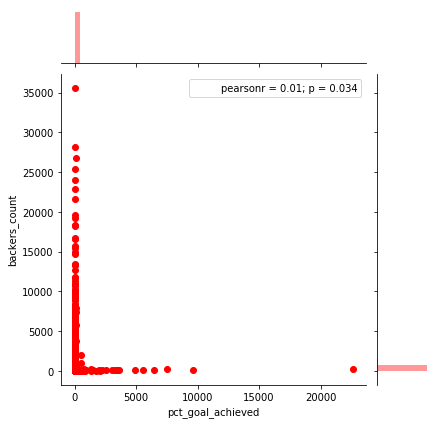

In [14]:
sns.jointplot(x='pct_goal_achieved',y='backers_count',data=df,color='red');

In [15]:
df.columns

Index(['id', 'name', 'state', 'category_main', 'category_name',
       'backers_count', 'pct_goal_achieved', 'usd_pledged', 'goal', 'country',
       'currency', 'campaign_length', 'deadline', 'launched', 'created',
       'spotlight', 'staff_pick', 'creator_name', 'blurb_length'],
      dtype='object')

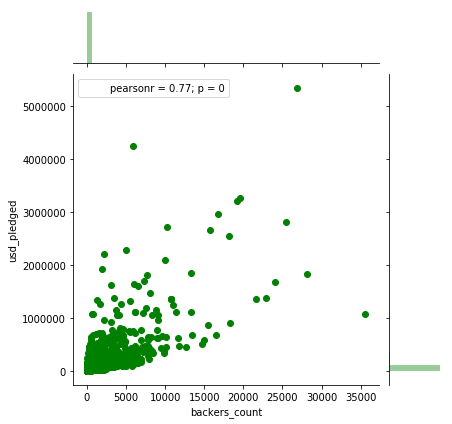

In [16]:
sns.jointplot(x='backers_count',y='usd_pledged',data=df,color='green')

In [17]:


# sns.set_style('whitegrid')
# df['pct_goal_achieved'].hist(bins=3000)
# plt.xlabel('pct_goal_achieved')
# # sns.plt.ylim(0,)
# plt.xlim(0,10)

In [18]:
df.staff_pick.sum()

5078

(2, 2)


Text(0,0.5,'Number of Campaigns')

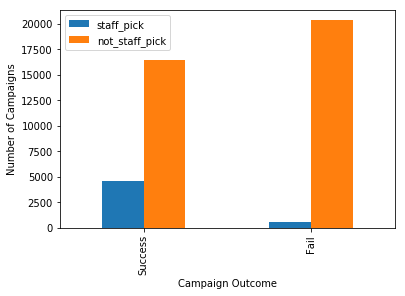

In [19]:
df['not_staff_pick'] = df['staff_pick'].replace({0: 1, 1:0})
df['state'] = df['state'].replace({0: "Fail", 1:"Success"})
# df['total'] = df['staff_pick'] + df['not_staff_pick']
df_staff_pick = df.groupby(["state"]).sum().sort_values(['staff_pick'], ascending=[False])
df_staff_pick = pd.DataFrame(df_staff_pick, columns={'staff_pick','not_staff_pick'})
print(df_staff_pick.shape)
df_staff_pick.plot(kind='bar')
# plt.plot(df_staff_pick, label='stuff')
plt.xlabel('Campaign Outcome')
plt.ylabel('Number of Campaigns')

In [20]:
# ax = sns.barplot(x="state", y='staff_pick', data=df)

# plt.xlabel('state', fontsize=12)
# plt.ylabel('staff_pick', fontsize=12)
# plt.tight_layout()
# # plt.savefig('charts/Top20.png')
# plt.show()

In [21]:
df_state = df.groupby(["state"]).count().sort_values(['name'], ascending=[False])
df_state = pd.DataFrame(df_state, columns={'name'})
print(df_state.shape)
df_state

(2, 1)


,name
state,
Success,21068
Fail,20826


(2, 2)


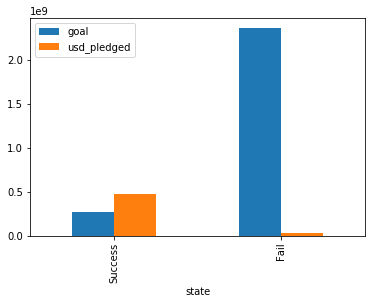

In [22]:
df_state = df.groupby(["state"]).sum().sort_values(['usd_pledged'], ascending=[False])
df_state = pd.DataFrame(df_state, columns={'usd_pledged','goal'})
print(df_state.shape)
df_state.plot(kind='bar')

(2, 1)


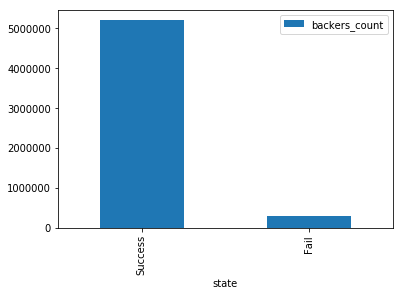

In [23]:
df_state = df.groupby(["state"]).sum().sort_values(['backers_count'], ascending=[False])
df_state = pd.DataFrame(df_state, columns={'backers_count'})
print(df_state.shape)
df_state.plot(kind='bar')

(44, 1)


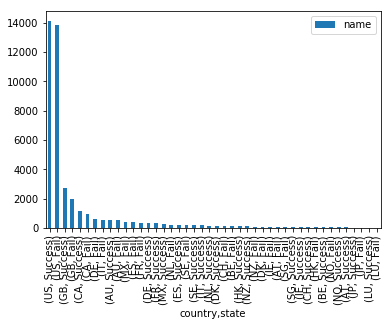

In [24]:
df_country = df.groupby(["country","state"]).count().sort_values(['name'], ascending=[False])
df_country = pd.DataFrame(df_country, columns={'name'})
print(df_country.shape)
df_country.plot(kind='bar')
plt.figsize=(20,10)

(44, 2)


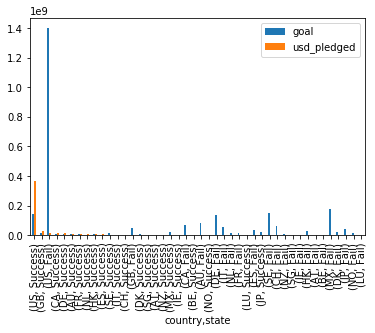

In [25]:
df_country = df.groupby(["country","state"]).sum().sort_values(['usd_pledged'], ascending=[False])
df_country = pd.DataFrame(df_country, columns={'usd_pledged','goal'})
print(df_country.shape)
df_country.plot(kind='bar')

(262, 1)


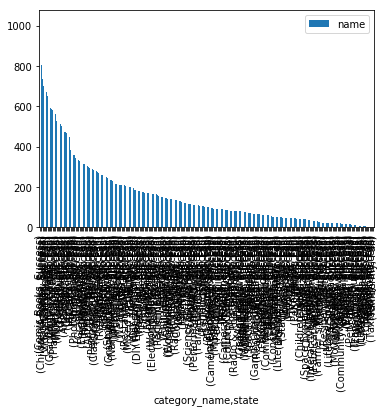

In [26]:
df_main_category = df.groupby(["category_name","state"]).count().sort_values(['name'], ascending=[False])
df_main_category = pd.DataFrame(df_main_category, columns={'name'})
print(df_main_category.shape)
df_main_category.plot(kind='bar')

(262, 2)


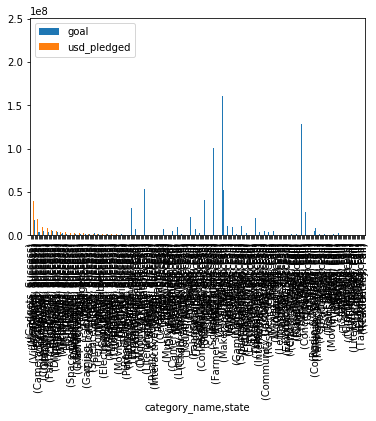

In [27]:
df_main_category = df.groupby(["category_name","state"]).sum().sort_values(['usd_pledged'], ascending=[False])
df_main_category = pd.DataFrame(df_main_category, columns={'usd_pledged', 'goal'})
print(df_main_category.shape)
df_main_category.plot(kind='bar')

In [29]:
# https://github.com/sagarvadher/KickstarterSuccessRatePredicton/blob/master/Kickstarter.ipynb
from sklearn.base import BaseEstimator
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from graphviz import Source
from sklearn import tree

ImportError: No module named 'graphviz'

In [ ]:
my_decisiontree = DecisionTreeClassifier( random_state = 100,max_depth=2)
my_decisiontree.fit(X_train, y_train)
y_predict = my_decisiontree.predict(X_test)
score = accuracy_score(y_test, y_predict)
print(score)

In [ ]:
feature_names = list(feature_matrix)
Source( tree.export_graphviz(my_decisiontree, out_file=None, feature_names=feature_names))

In [ ]:
from sklearn import linear_model
clf = linear_model.SGDClassifier()
clf.fit(X_train, y_train)

y_predict = clf.predict(X_test)
score = accuracy_score(y_test, y_predict)
print(score)